# Reference frames

rigid_body_motion provides a flexible high-performance framework for working offline with motion data. The core of this framework is a mechanism for constructing trees of both static and dynamic reference frames that supports automatic lookup and application of transformations across the tree.

<div class="alert alert-info">
Note

The following examples require the `matplotlib` library.
</div>

In [1]:
import numpy as np
import rigid_body_motion as rbm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

## Static frames

We will begin by defining a world reference frame using the [ReferenceFrame](_generated/rigid_body_motion.ReferenceFrame.rst) class:

In [2]:
rf_world = rbm.ReferenceFrame("world")

Now we can add a second reference frame as a child of the world frame. This frame is translated by 5 meters in the x direction and rotated 90° around the z axis. Note that rotations are represented as [unit quaternions](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation) by default.

In [3]:
rf_observer = rbm.ReferenceFrame(
    "observer",
    parent=rf_world,
    translation=(5, 0, 0),
    rotation=(np.sqrt(2) / 2, 0, 0, np.sqrt(2) / 2),
)

We can show the reference frame tree with the [render_tree](_generated/rigid_body_motion.render_tree.rst) function:

In [4]:
rbm.render_tree(rf_world)

world
└── observer


It is also possible to show a 3d plot of static reference frames with [plot.reference_frame()](_generated/rigid_body_motion.plot.reference_frame.rst):

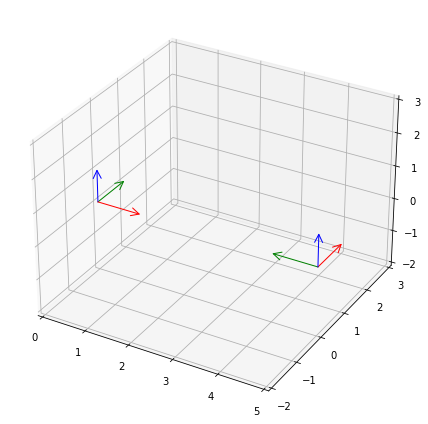

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)

fig.tight_layout()

To facilitate referring to previously defined frames, the library has a registry where frames can be stored by name with [ReferenceFrame.register()](_generated/rigid_body_motion.ReferenceFrame.register.rst):

In [6]:
rf_world.register()
rf_observer.register()
rbm.registry

{'world': <ReferenceFrame 'world'>, 'observer': <ReferenceFrame 'observer'>}

## Transformations

Now that we've set up a basic tree, we can use it to transform motion between reference frames. We use the [lookup_transform()](_generated/rigid_body_motion.lookup_transform.rst) method to obtain the transformation from the world to the observer frame:

In [7]:
t, r = rbm.lookup_transform(outof="world", into="observer")

This transformation consists of a translation $t$:

In [8]:
t

array([0., 5., 0.])

and a rotation $r$:

In [9]:
r

array([ 0.70710678,  0.        ,  0.        , -0.70710678])

### Position

rigid_body_motion uses the convention that a transformation is a rotation followed by a translation. Here, when applying the transformation to a point $p$ expressed with respect to (wrt) the world frame $W$ it yields the point wrt the observer frame $O$:

$$p_O = \operatorname{rot}\left(r, p_W\right) + t$$

The $\operatorname{rot}()$ function denotes the [rotation of a vector by a quaternion](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation#Using_quaternions_as_rotations).

Let's assume we have a rigid body located at 2 meters in the x direction from the origin of the world reference frame:

In [10]:
p_body_world = np.array((2, 0, 0))

We can add the body position to the plot with [plot.points()](_generated/rigid_body_motion.plot.points.rst):

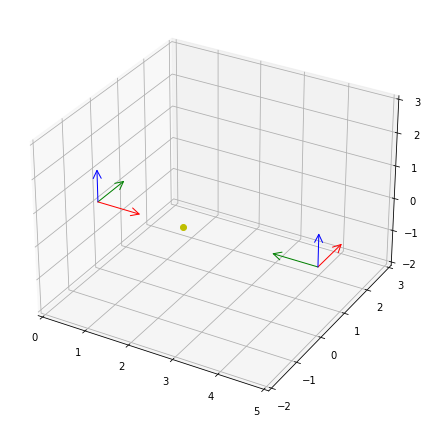

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)
rbm.plot.points(p_body_world, ax=ax, fmt="yo")

fig.tight_layout()

We can use the above formula to transform the position of the body into the observer frame. The [rotate_vectors()](_generated/rigid_body_motion.rotate_vectors.rst) method implements the rotation of a vector by a quaternion:

In [12]:
p_body_observer = rbm.rotate_vectors(r, p_body_world) + t
p_body_observer

array([0., 3., 0.])

As expected, the resulting position of the body is 3 meters from the observer in the y direction. For convenience, the [transform_points()](_generated/rigid_body_motion.transform_points.rst) method performs all of the above steps:

1. Lookup of the frames by name in the registry (if applicable)
2. Computing the transformation from the source to the target frame
3. Applying the transformation to the point(s)

In [13]:
p_body_observer = rbm.transform_points(p_body_world, outof="world", into="observer")
p_body_observer

array([0., 3., 0.])

### Orientation

Orientations expressed in quaternions are transformed by quaternion multiplication:

$$o_O = r \cdot o_W $$

This multiplication is implemented in the [qmul()](_generated/rigid_body_motion.qmul.rst) function to which you can pass an arbtrary number of quaternions to multiply. Assuming the body is oriented in the same direction as the world frame, transforming the orientation into the observer frame results in a rotation around the yaw axis:

In [14]:
o_body_world = np.array((1, 0, 0, 0))
rbm.qmul(r, o_body_world)

array([ 0.70710678,  0.        ,  0.        , -0.70710678])

We can add the orientation to the plot with [plot.quaternions()](_generated/rigid_body_motion.plot.quaternions.rst):

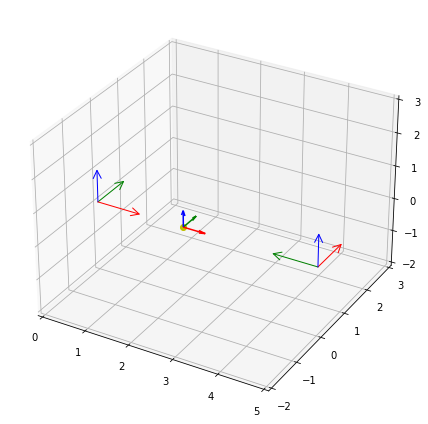

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)
rbm.plot.points(p_body_world, ax=ax, fmt="yo")
rbm.plot.quaternions(o_body_world, base=p_body_world, ax=ax)

fig.tight_layout()

Again, for convenience, the [transform_quaternions()](_generated/rigid_body_motion.transform_quaternions.rst) function can be used in the same way as [transform_points()](_generated/rigid_body_motion.transform_points.rst):

In [16]:
rbm.transform_quaternions(o_body_world, outof="world", into="observer")

array([ 0.70710678,  0.        ,  0.        , -0.70710678])

### Vectors

Let's assume the body moves in the x direction with a velocity of 1 m/s:

In [17]:
v_body_world = np.array((1, 0, 0))

We can add the velocity to the plot with [plot.vectors()](_generated/rigid_body_motion.plot.vectors.rst):

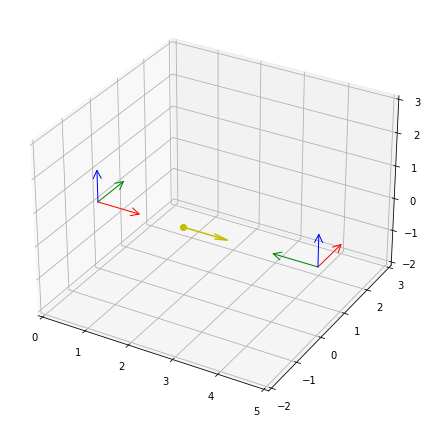

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)
rbm.plot.points(p_body_world, ax=ax, fmt="yo")
rbm.plot.vectors(v_body_world, base=p_body_world, ax=ax, color="y")

fig.tight_layout()

From the point of view of the observer, the body moves with the same speed, but in the negative y direction. Therefore, we need to apply a coordinate transformation to represent the velocity vector in the observer frame:

$$ v_O = \operatorname{rot}\left(r, v_W\right) $$

In [19]:
rbm.rotate_vectors(r, v_body_world)

array([ 0., -1.,  0.])

Like before, the [transform_vectors()](_generated/rigid_body_motion.transform_vectors.rst) function can be used in the same way as [transform_points()](_generated/rigid_body_motion.transform_points.rst):

In [20]:
rbm.transform_vectors(v_body_world, outof="world", into="observer")

array([ 0., -1.,  0.])

## Moving frames

Now, let's assume that the body moves from the origin of the world frame to the origin of the observer frame in 5 steps:

In [21]:
p_body_world = np.zeros((5, 3))
p_body_world[:, 0] = np.linspace(0, 5, 5)

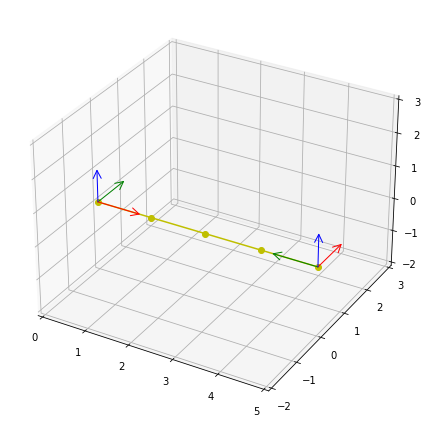

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)
rbm.plot.points(p_body_world, ax=ax, fmt="yo-")

fig.tight_layout()

We will now attach a reference frame to the moving body to explain the handling of moving reference frames. For this, we need to associate the positions of the body with corresponding timestamps:

In [23]:
ts_body = np.arange(5)

Let's construct the moving body frame and add it to the registry. We will use the [register_frame()](_generated/rigid_body_motion.register_frame.rst) convenience method:

In [24]:
rbm.register_frame("body", translation=p_body_world, timestamps=ts_body, parent="world")
rbm.render_tree("world")

world
├── observer
└── body


If we transform a static point from the world into the body frame its position will change over time, which is why [transform_points()](_generated/rigid_body_motion.transform_points.rst) will return an array of points even though we pass only a single point:

In [25]:
rbm.transform_points((2, 0, 0), outof="world", into="body")

array([[ 2.  ,  0.  ,  0.  ],
       [ 0.75,  0.  ,  0.  ],
       [-0.5 ,  0.  ,  0.  ],
       [-1.75,  0.  ,  0.  ],
       [-3.  ,  0.  ,  0.  ]])

One of the central features of the reference frame mechanism is its ability to consolidate arrays of timestamped motion even when the timestamps don't match. To illustrate this, let's create a second body moving in the y direction in world coordinates whose timestamps are offset by 0.5 seconds compared to the first body:

In [26]:
p_body2_world = np.zeros((5, 3))
p_body2_world[:, 1] = np.linspace(0, 2, 5)
ts_body2 = ts_body - 0.5

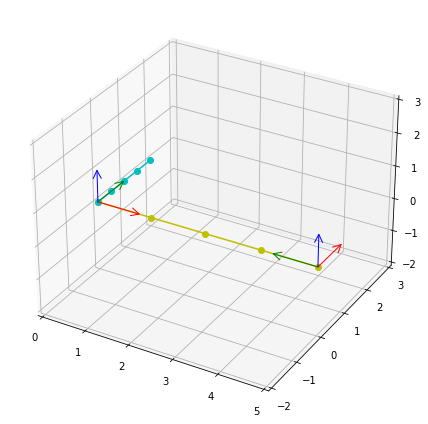

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame(rf_world, ax=ax)
rbm.plot.reference_frame(rf_observer, rf_world, ax=ax)
rbm.plot.points(p_body_world, ax=ax, fmt="yo-")
rbm.plot.points(p_body2_world, ax=ax, fmt="co-")

fig.tight_layout()

Transforming the position of the second body into the frame of the first body still works, despite the timestamp mismatch:

In [28]:
p_body2_body, ts_body2_body = rbm.transform_points(
    p_body2_world,
    outof="world",
    into="body",
    timestamps=ts_body2,
    return_timestamps=True,
)

This is because behind the scenes, [transform_points()](_generated/rigid_body_motion.transform_points.rst) matches the timestamps of the array to transform with those of the transformation across the tree by

1. computing the range of timestamps for which the transformation is defined,
2. intersecting that range with the range of timestamps to be transformed and
3. interpolating the resulting transformation across the tree to match the timestamps of the array.

Note that we specified `return_timestamps=True` to obtain the timestamps of the transformed array as they are different from the original timestamps. Let's plot the position of both bodies wrt the world frame as well as the position of the second body wrt the first body to see how the timestamp matching works:

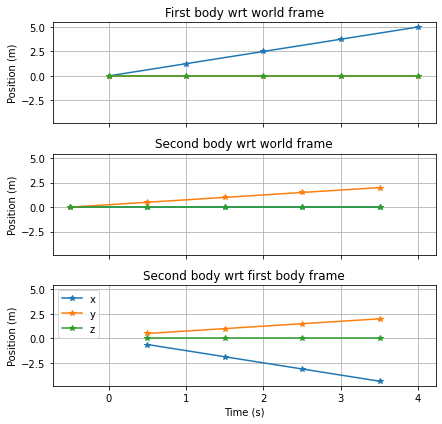

In [29]:
fig, axarr = plt.subplots(3, 1, sharex=True, sharey=True)

axarr[0].plot(ts_body, p_body_world, "*-")
axarr[0].set_ylabel("Position (m)")
axarr[0].set_title("First body wrt world frame")
axarr[0].grid("on")

axarr[1].plot(ts_body2, p_body2_world, "*-")
axarr[1].set_ylabel("Position (m)")
axarr[1].set_title("Second body wrt world frame")
axarr[1].grid("on")

axarr[2].plot(ts_body2_body, p_body2_body, "*-")
axarr[2].set_xlabel("Time (s)")
axarr[2].set_ylabel("Position (m)")
axarr[2].set_title("Second body wrt first body frame")
axarr[2].grid("on")
axarr[2].legend(["x", "y", "z"], loc="upper left")

fig.tight_layout()

As you can see, the resulting timestamps are the same as those of the second body; however, the first sample has been dropped because the transformation is not defined there.
